In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2

# Constants
MODEL_PATH = 'palm_detection_full.tflite'
IMAGE_PATH = 'IMG20241127102216.jpg'  # Replace with your image path
INPUT_SIZE = 192
MIN_DETECTION_CONFIDENCE = 0.5
NMS_THRESHOLD = 0.3
MAX_HANDS = 2

2024-12-04 16:58:06.071285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733327886.091651   48178 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733327886.099325   48178 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 16:58:06.122110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def calculate_scale(min_scale, max_scale, stride_index, num_strides):
    if num_strides == 1:
        return (min_scale + max_scale) * 0.5
    return min_scale + (max_scale - min_scale) * 1.0 * stride_index / (num_strides - 1.0)

In [3]:
import numpy as np
import cv2

class ImagePreprocessor:
    def __init__(self, input_size=(224, 224)):
        self.input_size = input_size  # (width, height)

    def preprocess(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocess the input image:
        - Resize to model's input size.
        - Normalize pixel values to [0, 1].
        - Expand dimensions to match model's input shape.
        """
        resized_image = cv2.resize(image, self.input_size)
        normalized_image = resized_image.astype(np.float32) / 255.0
        input_tensor = np.expand_dims(normalized_image, axis=0)  # Shape: (1, H, W, 3)
        return input_tensor

In [7]:
import numpy as np

class SsdAnchorsCalculator:
    def __init__(self, image_size, anchor_params):
        """
        Initialize anchor calculator.
        :param image_size: Tuple (width, height) of the image.
        :param anchor_params: Dictionary containing anchor generation parameters.
        """
        self.image_width, self.image_height = image_size
        self.anchor_params = anchor_params
        self.anchors = self.generate_anchors()

    def generate_anchors(self):
        """
        Generate anchor boxes based on SSD parameters.
        """
        anchors = []
        feature_map_sizes = self.anchor_params['feature_map_sizes']
        strides = self.anchor_params['strides']
        scales = self.anchor_params['scales']
        aspect_ratios = self.anchor_params['aspect_ratios']
        reduce_boxes_in_lowest_layer = self.anchor_params.get('reduceBoxesInLowestLayer', False)
        interpolated_scale_aspect_ratio = self.anchor_params.get('interpolatedScaleAspectRatio', 0.0)

        for idx, feature_map_size in enumerate(feature_map_sizes):
            stride = strides[idx]
            scale = scales[idx]
            aspect_ratio_list = []
            scale_list = []

            # Determine aspect ratios and scales based on layer
            if idx == 0 and reduce_boxes_in_lowest_layer:
                aspect_ratio_list.extend([1.0, 2.0, 0.5])
                scale_list.extend([0.1, scale, scale])
            else:
                for ar in aspect_ratios:
                    aspect_ratio_list.append(ar)
                    scale_list.append(scale)
                if interpolated_scale_aspect_ratio > 0.0:
                    if idx < len(scales) - 1:
                        scale_next = scales[idx + 1]
                    else:
                        scale_next = 1.0
                    scale_inter = np.sqrt(scale * scale_next)
                    aspect_ratio_list.append(interpolated_scale_aspect_ratio)
                    scale_list.append(scale_inter)

            # Compute anchor widths and heights
            anchor_width = []
            anchor_height = []
            for ar, sc in zip(aspect_ratio_list, scale_list):
                ratio_sqrt = np.sqrt(ar)
                anchor_height.append(sc / ratio_sqrt)
                anchor_width.append(sc * ratio_sqrt)

            # Generate anchors for each feature map location
            for y in range(feature_map_size[1]):
                for x in range(feature_map_size[0]):
                    center_x = (x + self.anchor_params.get('anchorOffsetX', 0.5)) * stride / self.image_width
                    center_y = (y + self.anchor_params.get('anchorOffsetY', 0.5)) * stride / self.image_height
                    for w, h in zip(anchor_width, anchor_height):
                        if self.anchor_params.get('fixedAnchorSize', True):
                            w_final = 1.0
                            h_final = 1.0
                        else:
                            w_final = w
                            h_final = h
                        anchors.append([center_x, center_y, w_final, h_final])

        anchors_array = np.array(anchors)  # Shape: (num_anchors, 4)
        print(f"Total anchors generated: {anchors_array.shape[0]}")  # Should print 2016
        return anchors_array

In [8]:
import numpy as np

class TensorsToDetections:
    def __init__(self, anchors, num_classes=1, score_threshold=0.5):
        """
        Initialize tensor decoder.
        :param anchors: Anchor boxes generated by SsdAnchorsCalculator.
        :param num_classes: Number of detection classes.
        :param score_threshold: Minimum score to consider a detection.
        """
        self.anchors = anchors
        self.num_classes = num_classes
        self.score_threshold = score_threshold

    def decode_boxes(self, box_outputs):
        decoded_boxes = []
        num_anchors = len(self.anchors)
        print(f"Anchor shape: {self.anchors.shape}")  # Shape: (num_anchors, 4)
        for i in range(num_anchors):
            if i >= box_outputs.shape[0]:
                print(f"Warning: Expected at least {num_anchors} box outputs, but got {box_outputs.shape[0]}")
                break
            tx, ty, tw, th = box_outputs[i][:4]
            anchor = self.anchors[i]
            cx = anchor[0] + tx * anchor[2]
            cy = anchor[1] + ty * anchor[3]
            decoded_boxes.append((cx, cy, tw, th))
        return decoded_boxes

    def decode_scores(self, score_outputs):
       """
       Decode scores from model outputs.
       """
       if len(score_outputs.shape) == 1:
           # Assuming single class; shape: (num_anchors,)
           scores = score_outputs
       elif len(score_outputs.shape) == 2:
           # Multiple classes; shape: (num_anchors, num_classes)
           scores = score_outputs[:, 0]  # Modify as per your class indexing
       else:
           raise ValueError(f"Unexpected score_outputs shape: {score_outputs.shape}")
       return scores

    def decode_detections(self, box_outputs, score_outputs, image_size, score_threshold=0.5):
        """
        Decode detections from model outputs.
        """
        decoded_boxes = self.decode_boxes(box_outputs)
        scores = self.decode_scores(score_outputs)

        # Filter by score threshold
        detections = []
        for box, score in zip(decoded_boxes, scores):
            if score >= score_threshold:
                # Convert normalized coordinates to image coordinates
                x_center = box[0] * image_size[0]
                y_center = box[1] * image_size[1]
                width = box[2] * image_size[0]
                height = box[3] * image_size[1]
                detections.append({
                    'box': (x_center, y_center, width, height),
                    'score': score
                })

        return detections

    def run(self, box_outputs, score_outputs, image_size):
        """
        Decode tensors to detections.
        """
        return self.decode_detections(box_outputs, score_outputs, image_size, score_threshold=self.score_threshold)

In [9]:
import numpy as np

class NonMaxSuppression:
    def __init__(self, iou_threshold=0.5, max_detections=100):
        """
        Initialize NMS.
        :param iou_threshold: IoU threshold for suppression.
        :param max_detections: Maximum number of detections to keep.
        """
        self.iou_threshold = iou_threshold
        self.max_detections = max_detections

    def compute_iou(self, box1, box2):
        """
        Compute Intersection over Union between two boxes.
        Boxes are in [cx, cy, w, h] format.
        """
        box1_x1 = box1[0] - box1[2] / 2
        box1_y1 = box1[1] - box1[3] / 2
        box1_x2 = box1[0] + box1[2] / 2
        box1_y2 = box1[1] + box1[3] / 2

        box2_x1 = box2[0] - box2[2] / 2
        box2_y1 = box2[1] - box2[3] / 2
        box2_x2 = box2[0] + box2[2] / 2
        box2_y2 = box2[1] + box2[3] / 2

        inter_x1 = max(box1_x1, box2_x1)
        inter_y1 = max(box1_y1, box2_y1)
        inter_x2 = min(box1_x2, box2_x2)
        inter_y2 = min(box1_y2, box2_y2)

        inter_area = max(inter_x2 - inter_x1, 0) * max(inter_y2 - inter_y1, 0)
        area1 = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
        area2 = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
        union_area = area1 + area2 - inter_area

        if union_area == 0:
            return 0
        else:
            return inter_area / union_area

    def run(self, detections):
        """
        Apply Non-Max Suppression to detections.
        :param detections: List of dicts with 'box' and 'score'.
        :return: Filtered list of detections.
        """
        if not detections:
            return []

        # Sort detections by score descending
        detections = sorted(detections, key=lambda x: x['score'], reverse=True)
        keep = []

        while detections and len(keep) < self.max_detections:
            current = detections.pop(0)
            keep.append(current)
            detections = [
                det for det in detections
                if self.compute_iou(current['box'], det['box']) < self.iou_threshold
            ]

        return keep

In [10]:
from typing import List, Dict

class ClipVectorSize:
    def __init__(self, max_size=100):
        """
        Initialize the clipper.
        :param max_size: Maximum number of elements to keep.
        """
        self.max_size = max_size

    def run(self, items: List[Dict]) -> List[Dict]:
        """
        Clip the list to the maximum size.
        """
        return items[:self.max_size]

In [36]:
import cv2
import numpy as np
import tensorflow as tf
class HandDetectorGraph:
    def __init__(self, model_path, anchor_params, input_size=(224, 224)):
        """
        Initialize the Hand Detector Graph pipeline.
        :param model_path: Path to the TFLite model.
        :param anchor_params: Parameters for anchor generation.
        :param input_size: Input image size expected by the model.
        """
        # Initialize components
        self.preprocessor = ImagePreprocessor(input_size=input_size)
        self.anchor_calculator = SsdAnchorsCalculator(
            image_size=(anchor_params['inputSizeWidth'], anchor_params['inputSizeHeight']),
            anchor_params=anchor_params
        )
        # Print anchor information
        print("\nAnchors:")
        anchors = self.anchor_calculator.anchors
        for i, anchor in enumerate(anchors):
            print(f"{anchor[0]},{anchor[1]},{anchor[2]},{anchor[3]}")
            
        self.detector = TensorsToDetections(
            anchors=self.anchor_calculator.anchors,
            num_classes=1,
            score_threshold=0.5
        )
        self.nms = NonMaxSuppression(iou_threshold=0.5, max_detections=100)
        self.clipper = ClipVectorSize(max_size=50)  # Example max size

        # Load TFLite model
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()

        # Get input and output details
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def run(self, image: np.ndarray):
        """
        Run the hand detection pipeline on an input image.
        :param image: Input RGB image as a NumPy array.
        :return: List of clipped hand rectangles.
        """
        # Preprocess image
        input_tensor = self.preprocessor.preprocess(image)

        # Set model input
        self.interpreter.set_tensor(self.input_details[0]['index'], input_tensor)

        # Run inference
        self.interpreter.invoke()

        # Get model outputs
        box_outputs = self.interpreter.get_tensor(self.output_details[0]['index'])  # Boxes
        score_outputs = self.interpreter.get_tensor(self.output_details[1]['index'])  # Scores

        # Print dimensions of model outputs
        print("Box outputs shape:", box_outputs.shape)
        print("Score outputs shape:", score_outputs.shape)

        # Decode detections with image_size parameter
        image_size = (self.anchor_calculator.image_width, self.anchor_calculator.image_height)
        detections = self.detector.run(box_outputs.squeeze(), score_outputs.squeeze(), image_size)

        # Apply Non-Max Suppression
        detections = self.nms.run(detections)

        # Clip detections to desired size
        clipped_detections = self.clipper.run(detections)
        # Pretty print clipped detections
        print("\nClipped Detections:")
        for i, detection in enumerate(clipped_detections):
            print(f"\nDetection {i+1}:")
            print(f"  Box coordinates: {detection['box']}")
            print(f"  Score: {detection['score']:.4f}")
            print(f"  Key points:")
            for j, kp in enumerate(detection.get('keypoints', [])):
                print(f"    Point {j+1}: {kp}")
        # Convert to rectangle coordinates
        hand_rects = [det['box'] for det in clipped_detections]

        return hand_rects

In [37]:
model_path = 'palm_detection_full.tflite'  # Ensure this path is correct
anchor_options = {
    'numLayers': 4,
    'minScale': 0.1484375,
    'maxScale': 0.75,
    'inputSizeWidth': 192,
    'inputSizeHeight': 192,
    'anchorOffsetX': 0.5,
    'anchorOffsetY': 0.5,
    'strides': [8, 16, 16, 16],
    'feature_map_sizes': [
        (24, 24),  # Layer 1
        (12, 12),  # Layer 2
        (12, 12),  # Layer 3
        (12, 12),  # Layer 4
    ],
    'aspect_ratios': [1.0, 0.5],  # Updated aspect ratios
    'fixedAnchorSize': True,
    'reduceBoxesInLowestLayer': False,  # Adjust if needed
    'interpolatedScaleAspectRatio': 0.0,  # Adjust if needed
}

# Compute scales using the defined calculate_scale function
scales = [calculate_scale(anchor_options['minScale'], anchor_options['maxScale'], i, len(anchor_options['strides'])) for i in range(len(anchor_options['strides']))]
anchor_options['scales'] = scales

print("Computed Scales:", scales)

input_size = (anchor_options['inputSizeWidth'], anchor_options['inputSizeHeight'])  # Model input size

# Initialize HandDetectorGraph
hand_detector = HandDetectorGraph(
    model_path=model_path,
    anchor_params=anchor_options,
    input_size=input_size
)

Computed Scales: [0.1484375, 0.34895833333333337, 0.5494791666666667, 0.75]
Total anchors generated: 2016

Anchors:
0.020833333333333332,0.020833333333333332,1.0,1.0
0.020833333333333332,0.020833333333333332,1.0,1.0
0.0625,0.020833333333333332,1.0,1.0
0.0625,0.020833333333333332,1.0,1.0
0.10416666666666667,0.020833333333333332,1.0,1.0
0.10416666666666667,0.020833333333333332,1.0,1.0
0.14583333333333334,0.020833333333333332,1.0,1.0
0.14583333333333334,0.020833333333333332,1.0,1.0
0.1875,0.020833333333333332,1.0,1.0
0.1875,0.020833333333333332,1.0,1.0
0.22916666666666666,0.020833333333333332,1.0,1.0
0.22916666666666666,0.020833333333333332,1.0,1.0
0.2708333333333333,0.020833333333333332,1.0,1.0
0.2708333333333333,0.020833333333333332,1.0,1.0
0.3125,0.020833333333333332,1.0,1.0
0.3125,0.020833333333333332,1.0,1.0
0.3541666666666667,0.020833333333333332,1.0,1.0
0.3541666666666667,0.020833333333333332,1.0,1.0
0.3958333333333333,0.020833333333333332,1.0,1.0
0.3958333333333333,0.0208333333333

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_hand_rects(image: np.ndarray, hand_rects: list, score_threshold: float = 0.5):
    """
    Visualize detected hand rectangles on the image.

    :param image: Original RGB image as a NumPy array.
    :param hand_rects: List of detected hand rectangles, each as a tuple (x_center, y_center, width, height).
                       Example: [(x_center1, y_center1, width1, height1), (x_center2, y_center2, width2, height2), ...]
    :param score_threshold: Minimum score threshold to visualize detections.
                            (Assuming each detection has an associated score; modify if necessary.)
    """
    # Create a figure and axis to plot on
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Iterate over each detected hand rectangle
    for idx, det in enumerate(hand_rects):
        x_center, y_center, width, height = det

        # Convert from normalized coordinates to absolute pixel values if necessary
        # (Assuming image_size corresponds to (width, height) used during detection)
        # If coordinates are already in pixel values, omit this step
        # Example assumes they are in pixel values based on previous steps

        # Calculate top-left corner coordinates
        x_min = x_center - (width / 2)
        y_min = y_center - (height / 2)

        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min),    # (x,y) of the top-left corner
            width,             # Rectangle width
            height,            # Rectangle height
            linewidth=2,       # Border width
            edgecolor='r',     # Border color
            facecolor='none'   # Fill color
        )

        # Add the Rectangle to the plot
        ax.add_patch(rect)

        # Optionally, add detection index or score
        # ax.text(x_min, y_min - 10, f'Det {idx+1}', color='red', fontsize=12, weight='bold')

    # Set title and display the plot
    plt.title("Hand Detections", fontsize=16)
    plt.axis('off')  # Hide axis
    plt.show()

In [29]:
image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [30]:
hand_rects = hand_detector.run(image_rgb)

Box outputs shape: (1, 2016, 18)
Score outputs shape: (1, 2016, 1)
Anchor shape: (2016, 4)

Clipped Detections:

Detection 1:
  Box coordinates: (np.float64(181.86793518066406), np.float64(764.5942535400391), np.float32(6300.958), np.float32(6290.753))
  Score: 3.2381
  Key points:

Detection 2:
  Box coordinates: (np.float64(-267.0485534667969), np.float64(-1014.6721496582031), np.float32(5477.629), np.float32(5469.697))
  Score: 0.7602
  Key points:


In [21]:
hand_rects

[(np.float64(181.86793518066406),
  np.float64(764.5942535400391),
  np.float32(6300.958),
  np.float32(6290.753)),
 (np.float64(-267.0485534667969),
  np.float64(-1014.6721496582031),
  np.float32(5477.629),
  np.float32(5469.697))]

In [23]:
image.shape

(1440, 1080, 3)

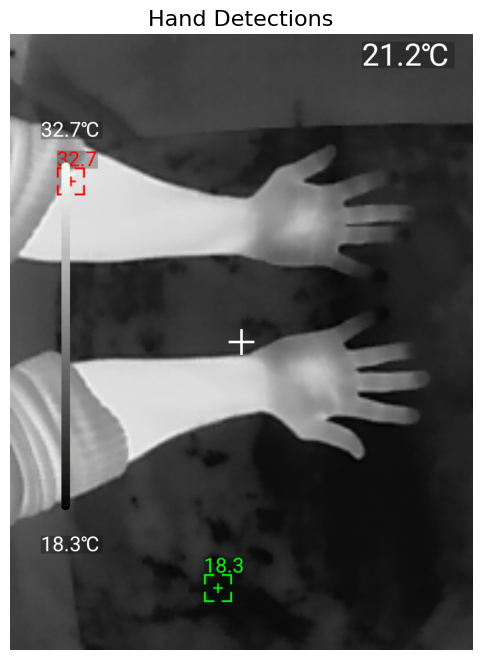

In [20]:
visualize_hand_rects(image_rgb, hand_rects)